<a href="https://colab.research.google.com/github/bscoder9595/BigDataProjects/blob/main/linearSvcVsLogistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [97]:
!pip install pyspark --quiet

In [98]:
import pyspark
from pyspark.sql import SparkSession
spark:SparkSession = SparkSession.builder \
    .master("local[4]") \
    .appName("logistic") \
    .getOrCreate()
sc = spark.sparkContext     

In [99]:
path = "/content/drive/MyDrive/csvFiles/ML_hw_dataset.csv"
dff = spark.read.csv(path,inferSchema=True,header=True)
df1 = dff
df2 = dff

In [100]:
dff.show(5)

+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job|marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 44|blue-collar|married|         basic.4y|unknown|    yes|  no|cellular|  aug|        thu|     210|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|
| 53| technician|married|          unknown|     no|     no|  no|cellular|  nov|        fri|     138|       1|  999|       0|nonexistent|        -0.1|          93.2|        -42.0|  

In [101]:
dff.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)



In [102]:
for m in dff.columns:
  dff.groupBy(m).count().show()

+---+-----+
|age|count|
+---+-----+
| 31| 1947|
| 85|   15|
| 65|   44|
| 53|  733|
| 78|   27|
| 34| 1745|
| 81|   20|
| 28| 1001|
| 76|   34|
| 27|  851|
| 26|  698|
| 44| 1011|
| 91|    2|
| 22|  137|
| 47|  928|
| 52|  779|
| 86|    8|
| 40| 1161|
| 20|   65|
| 94|    1|
+---+-----+
only showing top 20 rows

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+

+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 4612|
| married|24928|
|  single|11568|
+--------+-----+

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|


In [103]:
numeric_cols = [col_name for col_name , col_type in dff.dtypes if col_type in ['int','double','float']]
cat_cols = [col_name for col_name , col_type in dff.dtypes if col_type  not in ['int','double','float']]

At first we don`t preprocess the data


In [104]:
from pyspark.ml.feature import StringIndexer 

In [105]:
cat_cols_in = []

In [106]:
for c in cat_cols:
  cat_cols_in.append(c+"_in")
 

In [107]:
indexr_q = StringIndexer(inputCols=cat_cols,outputCols=cat_cols_in)
df1_in = indexr_q.fit(df1).transform(df1)


In [108]:
df1_in.show(4)

+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------+----------+------------+----------+----------+-------+----------+--------+--------------+-----------+
|age|        job|marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_in|marital_in|education_in|default_in|housing_in|loan_in|contact_in|month_in|day_of_week_in|poutcome_in|
+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------+----------+------------+----------+----------+-------+----------+--------+--------------+-----------+
| 44|blue-collar|married|         basic.4y|unknown|    yes|  

In [109]:
for c in cat_cols:
  df1_in = df1_in.drop(c)

In [110]:
from pyspark.ml.feature import VectorAssembler

In [111]:
vect_assem = [c for c in df1_in.columns if c!='y']


In [112]:
vec_assembeled = VectorAssembler(inputCols=vect_assem,outputCol='InputFeature')
df1_vectored= vec_assembeled.transform(df1_in)

In [113]:
df1_vectored = df1_vectored.select('InputFeature','y')

In [114]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [115]:
train_data1, test_data1 = df1_vectored.randomSplit([0.8,0.2])


In [165]:
train_data1.describe().show()

+-------+-------------------+
|summary|                  y|
+-------+-------------------+
|  count|              32951|
|   mean|0.11292525264787108|
| stddev|0.31650620865676227|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [166]:
test_data1.describe().show()

+-------+-------------------+
|summary|                  y|
+-------+-------------------+
|  count|               8237|
|   mean|0.11156974626684472|
| stddev| 0.3148554798451735|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [116]:
lr1 = LogisticRegression(featuresCol='InputFeature',labelCol='y',maxIter=5).fit(train_data1)
lr_train_result1 = lr1.evaluate(train_data1).predictions
lr_train_result1.show()

+--------------------+---+--------------------+--------------------+----------+
|        InputFeature|  y|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|(20,[0,1,2,3,4,5,...|  1|[0.41628157135874...|[0.60259312105828...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.84213014113075...|[0.94491045119890...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.37324826710200...|[0.79790445306830...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.47538988718557...|[0.92239844998909...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.54753897011069...|[0.92740800638520...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.34077884447756...|[0.91219848473079...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.91698278973160...|[0.94867960003032...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[3.55313009251423...|[0.97216226059103...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.55711596009513...|[0.92805011904205...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.54930791848

In [117]:
lr_test_results1 = lr1.evaluate(test_data1).predictions
lr_test_results1.show()

+--------------------+---+--------------------+--------------------+----------+
|        InputFeature|  y|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|(20,[0,1,2,3,4,5,...|  0|[3.12407292652935...|[0.95787487999391...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.50629830575847...|[0.92458217680650...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.21446302182384...|[0.90154079746763...|       0.0|
|(20,[0,1,2,3,4,5,...|  1|[-3.7362123955005...|[0.02328893774739...|       1.0|
|(20,[0,1,2,3,4,5,...|  1|[0.67282488937686...|[0.66213541032214...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[2.42283903635047...|[0.91855239644403...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.42806176224440...|[0.80659913621884...|       0.0|
|(20,[0,1,2,3,4,5,...|  1|[-0.2364908803940...|[0.44115129845223...|       1.0|
|(20,[0,1,2,3,4,5,...|  1|[-1.3577969185581...|[0.20459859405358...|       1.0|
|(20,[0,1,2,3,4,5,...|  0|[-1.3465218856

In [118]:
lsvc1 = LinearSVC(featuresCol='InputFeature',labelCol='y',maxIter=5).fit(train_data1)
lsvc_train_result1 = lsvc1.evaluate(train_data1).predictions
lsvc_train_result1.show()


+--------------------+---+--------------------+----------+
|        InputFeature|  y|       rawPrediction|prediction|
+--------------------+---+--------------------+----------+
|(20,[0,1,2,3,4,5,...|  1|[-0.3723645517083...|       1.0|
|(20,[0,1,2,3,4,5,...|  0|[1.47202803186908...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[0.90746431237829...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.32028038350565...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.36346989829199...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.28223230610765...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.51010337450529...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.75081671733713...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.35067403169029...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.36272394655532...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.56075337277465...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[0.83047606021575...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.64137667943165...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[0.18405967345287...|       0.

In [119]:
lsvc_test_results1 = lsvc1.evaluate(test_data1).predictions
lsvc_test_results1.show()

+--------------------+---+--------------------+----------+
|        InputFeature|  y|       rawPrediction|prediction|
+--------------------+---+--------------------+----------+
|(20,[0,1,2,3,4,5,...|  0|[1.60072147309626...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.34789742158941...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.22033244631239...|       0.0|
|(20,[0,1,2,3,4,5,...|  1|[-1.8024469485442...|       1.0|
|(20,[0,1,2,3,4,5,...|  1|[-0.4176191168080...|       1.0|
|(20,[0,1,2,3,4,5,...|  0|[1.25544497523672...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[0.85294124445983...|       0.0|
|(20,[0,1,2,3,4,5,...|  1|[-0.5584047849655...|       1.0|
|(20,[0,1,2,3,4,5,...|  1|[-0.8743304308099...|       1.0|
|(20,[0,1,2,3,4,5,...|  0|[-1.0205712347334...|       1.0|
|(20,[0,1,2,3,4,5,...|  0|[0.52685038238248...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.50333440539146...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[1.04360265686984...|       0.0|
|(20,[0,1,2,3,4,5,...|  0|[0.71927966381540...|       0.

We will preprocess data


In [120]:
from pyspark.sql.functions import col,isnan, when, count

In [121]:
df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df2.columns]
   ).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



In [122]:
import matplotlib.pyplot as plt
import pandas as pd

<Axes: >

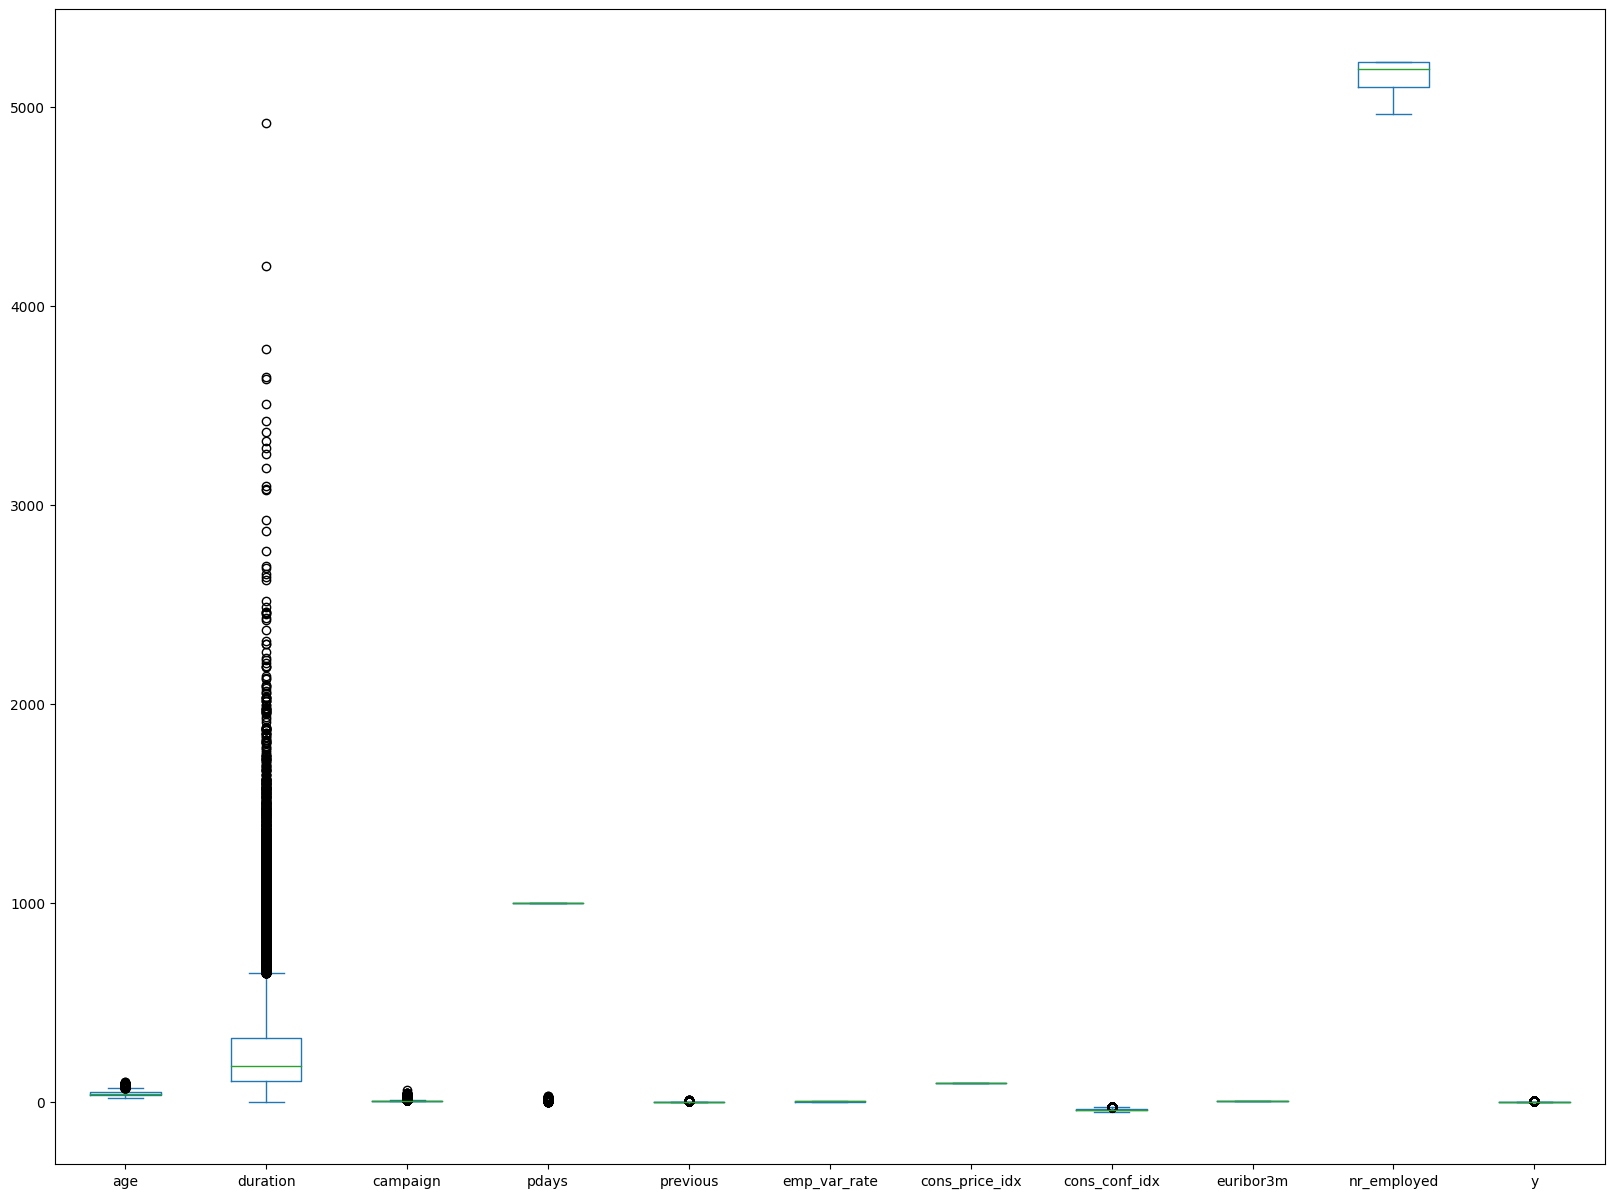

In [123]:
df2_p = df2.toPandas()
df2_p.plot.box(figsize=(20,15))

[array([17, 17], dtype=int32), array([69, 69], dtype=int32)]

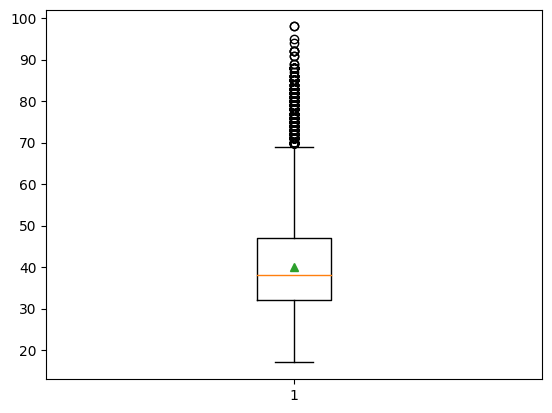

In [124]:
bp_age = plt.boxplot(df2_p['age'], showmeans=True,showcaps=True)
[item.get_ydata() for item in bp_age['caps']]


In [125]:
from pyspark.sql.functions import when

df2 = df2.withColumn("age", when(df2.age>69, 69).otherwise(df2.age))


In [126]:
df2.filter('age>69').show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



In [127]:
df2.select('age').count()

41188

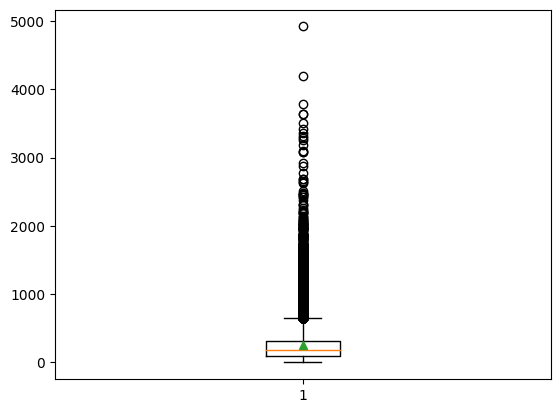

In [128]:
bp_duration = plt.boxplot(df2_p['duration'], showmeans=True,showcaps=True)
[item.get_ydata() for item in bp_duration['caps']]
df2 = df2.withColumn("duration", when(df2.duration>644, 644).otherwise(df2.duration))


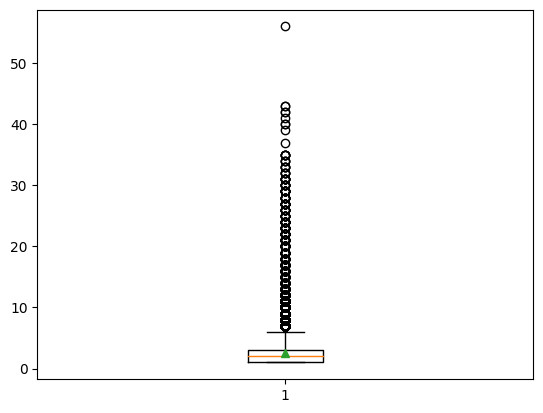

In [129]:
bp_campaign = plt.boxplot(df2_p['campaign'], showmeans=True,showcaps=True)
[item.get_ydata() for item in bp_campaign['caps']]

df2 = df2.withColumn("campaign", when(df2.duration>6, 6).otherwise(df2.campaign))


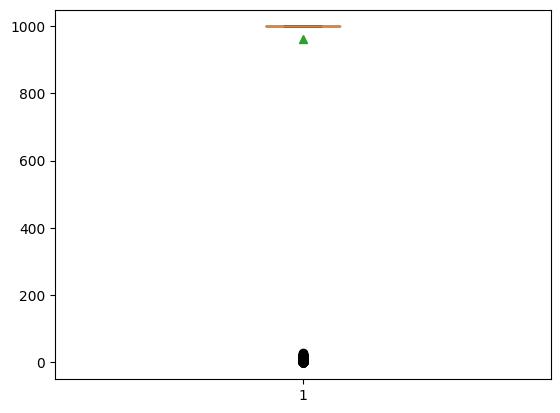

In [130]:
bp_pdays = plt.boxplot(df2_p['pdays'], showmeans=True,showcaps=True)
[item.get_ydata() for item in bp_pdays['caps']]

df2 = df2.withColumn("pdays", when(df2.pdays>999, 999).otherwise(df2.pdays))
df2 = df2.withColumn("pdays", when(df2.pdays<999, 999).otherwise(df2.pdays))


[array([0, 0], dtype=int32), array([0, 0], dtype=int32)]

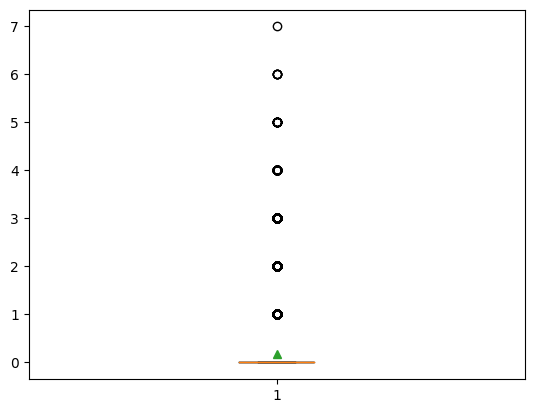

In [131]:
bp_pervious = plt.boxplot(df2_p['previous'], showmeans=True,showcaps=True)
[item.get_ydata() for item in bp_pervious['caps']]



In [132]:

df2 = df2.withColumn("previous", when(df2.previous>0, 0).otherwise(df2.previous))
df2 = df2.withColumn("previous", when(df2.previous<0, 0).otherwise(df2.previous))

[array([-50.8, -50.8]), array([-29.8, -29.8])]

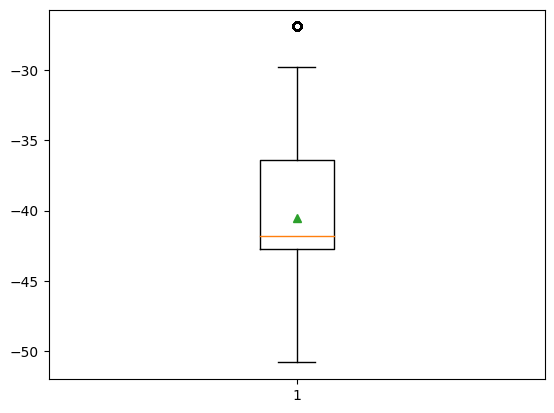

In [133]:
bp_cons_conf_idx = plt.boxplot(df2_p['cons_conf_idx'], showmeans=True,showcaps=True)
[item.get_ydata() for item in bp_cons_conf_idx['caps']]




In [134]:

df2 = df2.withColumn("cons_conf_idx", when(df2.cons_conf_idx>-29.8, -29.8).otherwise(df2.cons_conf_idx))

[array([0, 0], dtype=int32), array([0, 0], dtype=int32)]

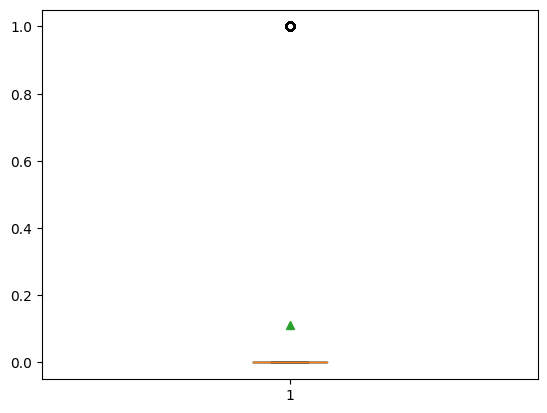

In [135]:
bp_y = plt.boxplot(df2_p['y'], showmeans=True,showcaps=True)
[item.get_ydata() for item in bp_y['caps']]




In [136]:

df2 = df2.withColumn("y", when(df2.y>1, 1).otherwise(df2.y))
df2 = df2.withColumn("y", when(df2.y<0, 0).otherwise(df2.y))

In [137]:
df2.show(5)

+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job|marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 44|blue-collar|married|         basic.4y|unknown|    yes|  no|cellular|  aug|        thu|     210|       6|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|
| 53| technician|married|          unknown|     no|     no|  no|cellular|  nov|        fri|     138|       6|  999|       0|nonexistent|        -0.1|          93.2|        -42.0|  

In [138]:
df2.describe().show()

+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+-------------------+-----+--------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|          duration|           campaign|pdays|previous|poutcome|       emp_var_rate|    cons_price_idx|     cons_conf_idx|         euribor3m|      nr_employed|                  y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+-------------------+-----+--------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|    41188|41188|      41188|             41188|              41188|4118

<Axes: >

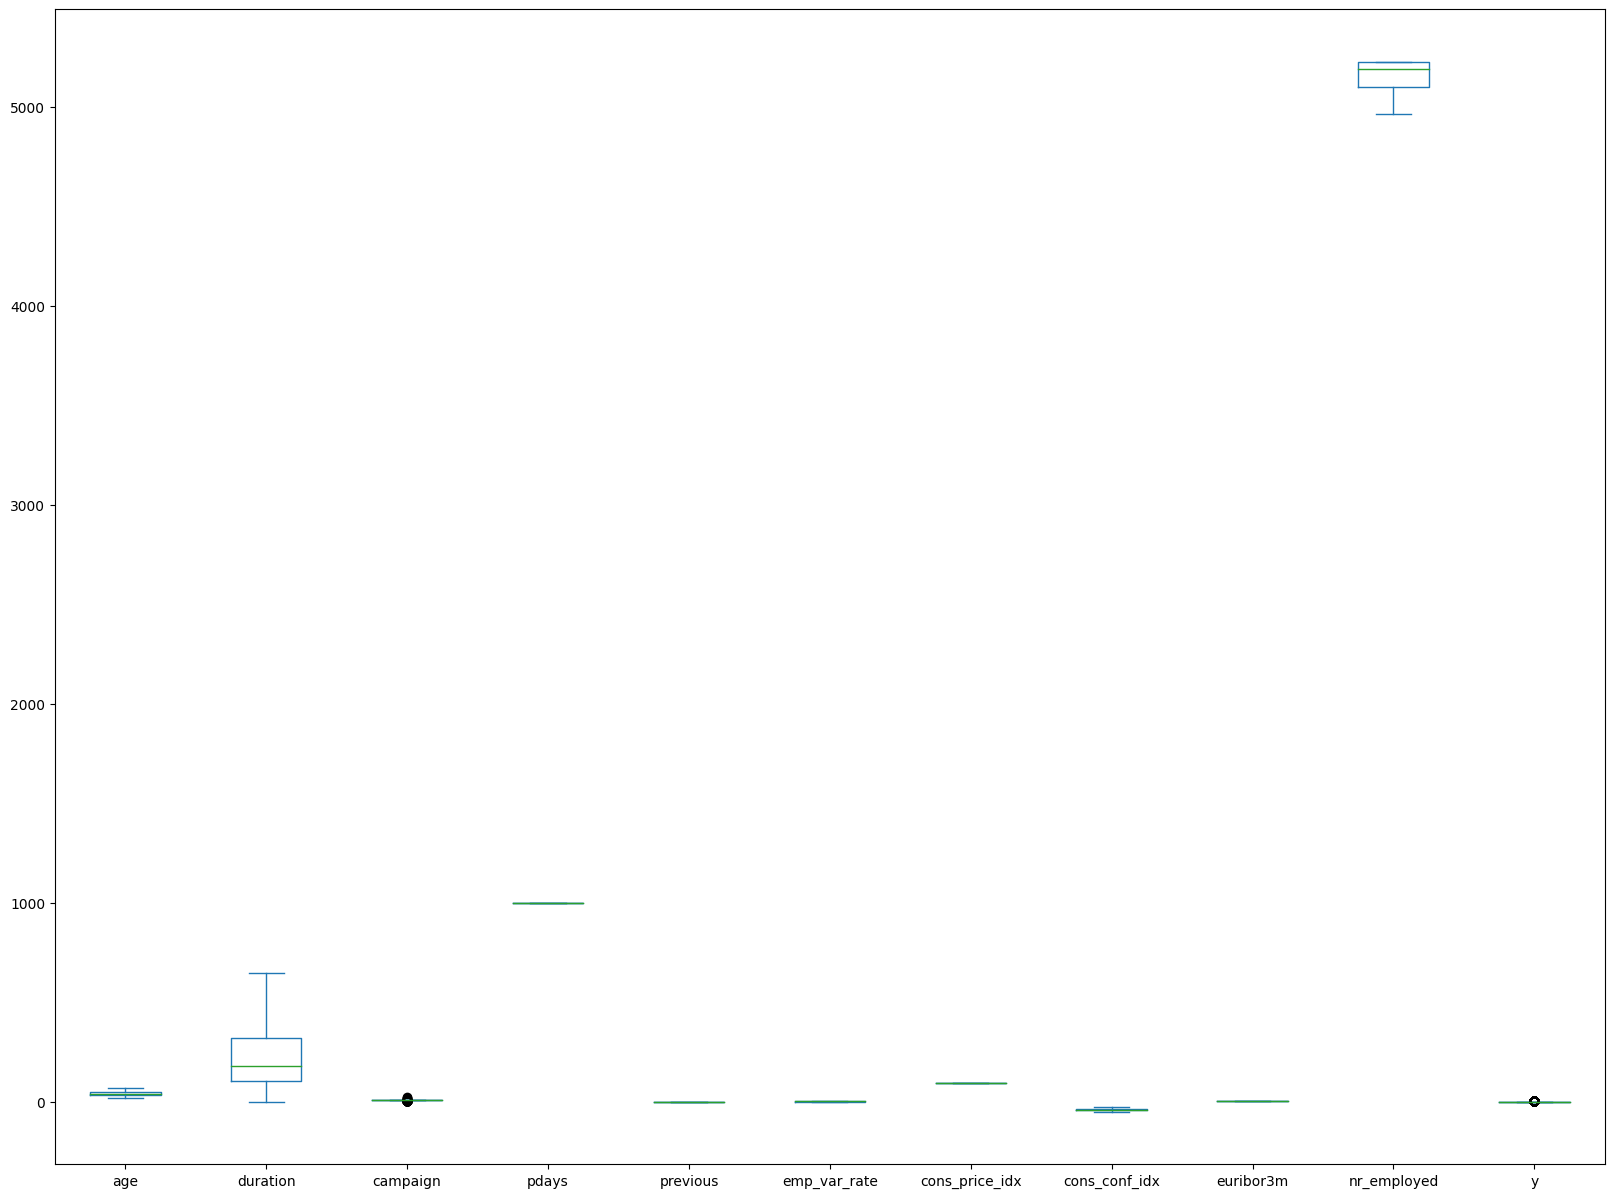

In [139]:
df22_p = df2.toPandas()
df22_p.plot.box(figsize=(20,15))

In [140]:
cat_cols_in2 = []

In [141]:
for c in cat_cols:
  cat_cols_in2.append(c+"_in")

In [142]:
indexr_q2 = StringIndexer(inputCols=cat_cols,outputCols=cat_cols_in2)
df2_in = indexr_q2.fit(df2).transform(df2)

In [91]:
df2_in.show(5)

+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------+----------+------------+----------+----------+-------+----------+--------+--------------+-----------+
|age|        job|marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_in|marital_in|education_in|default_in|housing_in|loan_in|contact_in|month_in|day_of_week_in|poutcome_in|
+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------+----------+------------+----------+----------+-------+----------+--------+--------------+-----------+
| 44|blue-collar|married|         basic.4y|unknown|    yes|  

In [143]:
for c in cat_cols:
  df2_in = df2_in.drop(c)

In [144]:
df2_in.columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y',
 'job_in',
 'marital_in',
 'education_in',
 'default_in',
 'housing_in',
 'loan_in',
 'contact_in',
 'month_in',
 'day_of_week_in',
 'poutcome_in']

In [145]:
vect_assem2 = [c for c in df2_in.columns if c!='y']


In [146]:
corr_cols = [c for c in vect_assem2 if df2_in.stat.corr(c,'y')>0.2 or df2_in.stat.corr(c,'y')<-0.2]


In [148]:
vec_assembeled2 = VectorAssembler(inputCols=corr_cols,outputCol='InputFeature2')
df2_vectored= vec_assembeled2.transform(df2_in)

In [149]:
df2_vectored = df2_vectored.select('InputFeature2','y')

In [151]:
df2_vectored.show(5)

+--------------------+---+
|       InputFeature2|  y|
+--------------------+---+
|[210.0,1.4,4.963,...|  0|
|[138.0,-0.1,4.021...|  0|
|[339.0,-1.7,0.729...|  1|
|[185.0,-1.8,1.405...|  0|
|[137.0,-2.9,0.869...|  1|
+--------------------+---+
only showing top 5 rows



In [150]:
from pyspark.ml.feature import StandardScaler


In [153]:
scaler = StandardScaler(inputCol="InputFeature2", outputCol="scaledFeatures2",
                        withStd=True, withMean=False)
scalerModel = scaler.fit(df2_vectored)
scaledData = scalerModel.transform(df2_vectored)
scaledData = scaledData.select('scaledFeatures2','y')
scaledData.show()

+--------------------+---+
|     scaledFeatures2|  y|
+--------------------+---+
|[1.18463172177307...|  0|
|[0.77847227430801...|  0|
|[1.91233406514796...|  1|
|[1.04360413584770...|  0|
|[0.77283117087100...|  1|
|[0.38359503371699...|  0|
|[1.15078510115098...|  0|
|[1.07745075646979...|  0|
|[0.98155199804054...|  1|
|[1.07745075646979...|  0|
|[0.34974841309490...|  0|
|[3.63287061343742...|  0|
|[2.09849047856944...|  1|
|[0.42308275777609...|  0|
|[3.63287061343742...|  0|
|[0.66000910213071...|  0|
|[3.63287061343742...|  1|
|[3.04619585598790...|  1|
|[0.78975448118204...|  0|
|[0.58667475744952...|  0|
+--------------------+---+
only showing top 20 rows



In [154]:
train_data2, test_data2 = scaledData.randomSplit([0.8,0.2])


In [156]:
lr2 = LogisticRegression(featuresCol='scaledFeatures2',labelCol='y',maxIter=5).fit(train_data2)
lr2_train_result2 = lr2.evaluate(train_data2).predictions
lr2_train_result2.show()

+--------------------+---+--------------------+--------------------+----------+
|     scaledFeatures2|  y|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[0.0,-1.145796390...|  0|[4.17639019959714...|[0.98487834345262...|       0.0|
|[0.0,-1.145796390...|  0|[3.33898318567275...|[0.96574221775925...|       0.0|
|[0.0,0.7002089051...|  0|[5.31344070937751...|[0.99509918408114...|       0.0|
|[0.00564110343701...|  0|[1.09226392594105...|[0.74880779385340...|       0.0|
|[0.00564110343701...|  0|[1.63639779305804...|[0.83704418836593...|       0.0|
|[0.01128220687402...|  0|[4.47483326421131...|[0.98873619716921...|       0.0|
|[0.01692331031104...|  0|[5.29278878859523...|[0.99499743206436...|       0.0|
|[0.01692331031104...|  0|[5.29287914096333...|[0.99499788177698...|       0.0|
|[0.02256441374805...|  0|[3.12890177614562...|[0.95806929671069...|       0.0|
|[0.02256441374805...|  0|[3.29972621655

In [158]:
lr2_test_results2 = lr2.evaluate(test_data2).predictions
lr2_test_results2.show()

+--------------------+---+--------------------+--------------------+----------+
|     scaledFeatures2|  y|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[0.02256441374805...|  0|[4.14400539479933...|[0.98438838598222...|       0.0|
|[0.02820551718507...|  0|[3.59699317574073...|[0.97332505005786...|       0.0|
|[0.02820551718507...|  0|[2.74819637908659...|[0.93981140723265...|       0.0|
|[0.02820551718507...|  0|[3.29242059857168...|[0.96416787542606...|       0.0|
|[0.02820551718507...|  0|[3.29323376988459...|[0.96419595841631...|       0.0|
|[0.02820551718507...|  0|[2.15185130246938...|[0.89584164741950...|       0.0|
|[0.02820551718507...|  0|[2.33189168442033...|[0.91148407830665...|       0.0|
|[0.02820551718507...|  0|[5.27917142868721...|[0.99492919215953...|       0.0|
|[0.02820551718507...|  0|[5.36978623452287...|[0.99536644348162...|       0.0|
|[0.03384662062208...|  0|[4.13083979673

In [159]:
lsvc2 = LinearSVC(featuresCol='scaledFeatures2',labelCol='y',maxIter=5).fit(train_data2)
lsvc2_train_result2 = lsvc2.evaluate(train_data2).predictions
lsvc2_train_result2.show()

+--------------------+---+--------------------+----------+
|     scaledFeatures2|  y|       rawPrediction|prediction|
+--------------------+---+--------------------+----------+
|[0.0,-1.145796390...|  0|[1.85628383939149...|       0.0|
|[0.0,-1.145796390...|  0|[1.51982029012239...|       0.0|
|[0.0,0.7002089051...|  0|[2.11317290900073...|       0.0|
|[0.00564110343701...|  0|[0.39605746629953...|       0.0|
|[0.00564110343701...|  0|[0.73437555788533...|       0.0|
|[0.01128220687402...|  0|[1.83689837270747...|       0.0|
|[0.01692331031104...|  0|[2.10746903329259...|       0.0|
|[0.01692331031104...|  0|[2.10747740898830...|       0.0|
|[0.02256441374805...|  0|[1.46526308155151...|       0.0|
|[0.02256441374805...|  0|[1.53286569214681...|       0.0|
|[0.02256441374805...|  0|[1.46527983294294...|       0.0|
|[0.02256441374805...|  0|[0.45877701936685...|       0.0|
|[0.02256441374805...|  0|[1.70473909490842...|       0.0|
|[0.02256441374805...|  0|[2.10556215759273...|       0.

In [160]:
lsvc2_test_results2 = lsvc2.evaluate(test_data2).predictions
lsvc2_test_results2.show()

+--------------------+---+--------------------+----------+
|     scaledFeatures2|  y|       rawPrediction|prediction|
+--------------------+---+--------------------+----------+
|[0.02256441374805...|  0|[1.84822917611055...|       0.0|
|[0.02820551718507...|  0|[1.50838111513211...|       0.0|
|[0.02820551718507...|  0|[1.19259884638258...|       0.0|
|[0.02820551718507...|  0|[1.53092531366409...|       0.0|
|[0.02820551718507...|  0|[1.53100069492554...|       0.0|
|[0.02820551718507...|  0|[1.06498238971454...|       0.0|
|[0.02820551718507...|  0|[1.13343932127286...|       0.0|
|[0.02820551718507...|  0|[2.10368040898002...|       0.0|
|[0.02820551718507...|  0|[2.12349516509300...|       0.0|
|[0.03384662062208...|  0|[1.84448243027656...|       0.0|
|[0.03384662062208...|  0|[1.50622296856078...|       0.0|
|[0.03384662062208...|  0|[1.84535350263101...|       0.0|
|[0.03384662062208...|  0|[1.46148283293466...|       0.0|
|[0.03384662062208...|  0|[1.82819878085641...|       0.

In [95]:
lsvc2_test_results2 , lr2_test_results2 , lsvc_test_result1 , lr_test_result1

In [161]:
evaluatorlr1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="accuracy")
accuracylr1 = evaluatorlr1.evaluate(lr_test_results1)
print("Accuracylr1 = %g" % accuracylr1)
evaluatorlr12 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="weightedPrecision")
precisionlr1 = evaluatorlr12.evaluate(lr_test_results1)
print("Precisionlr1 = %g" % precisionlr1)

evaluatorlr13 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="weightedRecall")
recalllr1 = evaluatorlr13.evaluate(lr_test_results1)
print("Recalll1 = %g" % recalllr1)

Accuracylr1 = 0.907491
Precisionlr1 = 0.893859
Recalll1 = 0.907491


In [162]:
evaluatorls1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="accuracy")
accuracyls1 = evaluatorls1.evaluate(lsvc_test_results1)
print("Accuracyls1 = %g" % accuracyls1)
evaluatorls12 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="weightedPrecision")
precisionls1 = evaluatorls12.evaluate(lsvc_test_results1)
print("Precisionls1 = %g" % precisionls1)

evaluatorls13 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="weightedRecall")
recallls1 = evaluatorls13.evaluate(lsvc_test_results1)
print("Recallls1 = %g" % recallls1)

Accuracyls1 = 0.905912
Precisionls1 = 0.890954
Recallls1 = 0.905912


In [163]:
evaluatorlr2 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="accuracy")
accuracylr2 = evaluatorlr2.evaluate(lr2_test_results2)
print("Accuracylr2 = %g" % accuracylr2)
evaluatorlr22 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="weightedPrecision")
precisionlr2 = evaluatorlr22.evaluate(lr2_test_results2)
print("Precisionlr2 = %g" % precisionlr2)

evaluatorlr23 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="weightedRecall")
recalllr2 = evaluatorlr23.evaluate(lr2_test_results2)
print("Recalllr2 = %g" % recalllr2)

Accuracylr2 = 0.904974
Precisionlr2 = 0.890417
Recalllr2 = 0.904974


In [164]:
evaluatorls2 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="accuracy")
accuracyls2 = evaluatorls2.evaluate(lsvc2_test_results2)
print("Accuracy = %g" % accuracyls2)
evaluatorls22 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="weightedPrecision")
precisionls2 = evaluatorls22.evaluate(lsvc2_test_results2)
print("Precision = %g" % precisionls2)

evaluatorls23 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="y", metricName="weightedRecall")
recallls2 = evaluatorls23.evaluate(lsvc2_test_results2)
print("Recallls2 = %g" % recallls2)

Accuracy = 0.898787
Precision = 0.892542
Recallls2 = 0.898787
